Looking a bit into ancestry for all (based on Globetrotter) and male chrX

In [1]:
%run ../scripts/notebook_settings_lean.py
from horizonplot import horizonplot

In [2]:
#Functions to generate the stacked area plot df

#Should be easily extendable to multiple paintings by repeating the loop
def length_to_windows(length_df, window_size=100000):
    pops = sorted(length_df["pop"].unique())
    window_l = list(range(length_df.pos.values[0], length_df.end_pos.values[-1], window_size))
    overall_dict = {"windows": window_l}
    for p in pops:
        overall_dict[p] = np.zeros(len(window_l))
    for i in range(len(window_l)):
        w = window_l[i]
        # Finding all paintings that start in this window.
        s_df = length_df.loc[(length_df.pos >= w) & (length_df.pos < w+window_size)]
        for index, row in s_df.iterrows():
            # x decides how many windows it should go beyond the current.
            # if x==0, it both starts and ends in the same window
            x = (row.pos-w+row.paint_length)//window_size
            if x == 0:
                overall_dict[row["pop"]][i] += int(row.paint_length)
            # Otherwise, the current window is filled from row.pos to window end
            else:
                overall_dict[row["pop"]][i] += int((w+window_size)-row.pos)
                # Then iterated for each full window (which is all windows < x)
                for s in range(x-1):
                    overall_dict[row["pop"]][i+1+s] += int(window_size)
                # Then finally added the ending window
                # print(row.paint_length+row.pos, (w+x*window_size), x, w)
                overall_dict[row["pop"]][i+x] += int(row.paint_length+row.pos-(w+x*window_size))
    df = pd.DataFrame(overall_dict)
    return df

def generate_spot_df(single_p_df, map_dict):
    single_p_df["pop"] = single_p_df["paint"].map(map_dict)
    shift_spots = (single_p_df["pop"] != single_p_df["pop"].shift())
    #df based on this subset
    spot_df = single_p_df.loc[shift_spots].copy()
    #Finding the start of the next painting, by removing the first pos and adding the last snp.
    #And then calculating the difference.
    spot_df["paint_length"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-spot_df["pos"].values)
    spot_df["end_pos"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-1)
    return spot_df

def create_paint_df_lengths(paintfile, idfile, haploid=False):
    #various supplemental dataframes/lists
    end_pos = pos_list.values[-1]
    
    map_dict = {}
    if haploid==False:
        h = 2
    else:
        h = 1
    for i, row in idfile.iterrows():
        map_dict[row.ID_index*h+1] = row["pop"]
        map_dict[row.ID_index*h+2] = row["pop"]

    df_l = []
    f = open(paintfile, "r")
    ad_lines = f.readlines()
    ind = ""
    hap = ""
    for p_num in range(1, len(ad_lines)):
        l = ad_lines[p_num].strip().split(" ")
        if l[0] == "HAP":
            ind = l[2]
            if haploid==False:
                if hap == 1:
                    hap = 2
                else:
                    hap = 1
            else:
                hap = 1
        else:
            paint_line = l[1:]
            single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
            single_p_df = single_p_df.astype(int)
            spot_df = generate_spot_df(single_p_df, map_dict)
            spot_df["individual"] = ind
            spot_df["haplotype"] = hap
            df_l.append(spot_df)
    all_df = pd.concat(df_l)
    return all_df

In [60]:
def fun(a, b, markercat, markers, jitter=0.2, dodge=0.3, label=None, data=None, **kwargs):
    offsets = dict((zip(data[markercat].cat.categories, np.linspace(-1, 1, len(data[markercat].cat.categories)))))
    colors = dict(zip(data[b].cat.categories.values, sns.color_palette()))    
    ax = sns.stripplot(x=data[a], y=data[b], 
                       palette=sns.color_palette(['white']),
                      )
    for name, group in data.groupby(b):
        sc = plt.scatter(group[a], np.array(
                        group[b].cat.codes.values) + \
                        jitter*np.random.random(size=len(group[b].cat.codes.values)) + \
                        offsets[label]*dodge, 
                    color=colors[name],
                    marker=markers[label], zorder=10, s=20)

Create the paint lengths from the underlying dataset and then saving them as a single file

Male chrX (haploid)

In [5]:
idfile_path = "/home/eriks/baboondiversity/data/haploidified_chrX_males/idfile_males_8_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
recomb_map_path = "/home/eriks/baboondiversity/data/haploidified_chrX_males/chr{}.males.recombfile"
idfile = idfile.loc[idfile.inclusion == 1]
os.makedirs("../steps/paint_summary/", exist_ok=True)
chrom_list = ["X"]
window_length = 100000
df_l = []
for chrom in chrom_list:
    recomb_map = pd.read_csv(recomb_map_path.format(chrom, chrom), sep=" ")
    pos_list = recomb_map["start.pos"]
    for population in sorted(idfile["pop"].unique()):
        print(population)
        pop_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/" \
                        "chr{}_males_8_cluster/{}_chr{}_males_8_cluster/chr{}.samples.out"\
                        .format(chrom, population, chrom, chrom)
        length_df = create_paint_df_lengths(pop_path, idfile, haploid=True)
        length_df["chrom"] = chrom
        length_df["C_origin"] = population
        df_l.append(length_df)
length_df_chrX_males = pd.concat(df_l)

Anubis_Ethiopia
Anubis_Tanzania
Cynocephalus_Central_Tanzania
Cynocephalus_Western_Tanzania
Hamadryas_Ethiopia
Kindae_Zambia
Papio_Senegal
Ursinus_Zambia


Saving the data

In [6]:
#length_df_chrX_males.to_csv("../steps/paint_summary/"+"length_df_chrX_males", sep=" ", index=False)
pd.read_csv("../steps/paint_summary/"+"length_df_chrX_males", sep=" ")

Also running and saving the autosomal from the underlying Globetrotter data

In [8]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chr{}/chr{}.filtered.all.recombfile"

idfile = idfile.loc[idfile.inclusion == 1]
os.makedirs("../steps/paint_summary/", exist_ok=True)
chrom_list = ["8"]
window_length = 100000
df_l = []
for chrom in chrom_list:
    recomb_map = pd.read_csv(recomb_map_path.format(chrom, chrom), sep=" ")
    pos_list = recomb_map["start.pos"]
    for population in sorted(idfile["pop"].unique()):
        print(population)
        pop_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/" \
                        "all_autosomes_8_cluster/{}_all_autosomes_8_cluster/chr{}.samples.out"\
                        .format(population, chrom)
        length_df = create_paint_df_lengths(pop_path, idfile)
        length_df["chrom"] = chrom
        length_df["C_origin"] = population
        df_l.append(length_df)
length_df_chr8_all = pd.concat(df_l)

anubis_ethiopia
anubis_tanzania
cyno_central
cyno_western
hamadryas
kindae
papio
ursinus


In [9]:
length_df_chr8_all.to_csv("../steps/paint_summary/"+"length_df_chr8_all", sep=" ", index=False)
#pd.read_csv("../steps/paint_summary/"+"length_df_chr8_all", sep=" ")

In [44]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chr{}/chr{}.females.recombfile"

os.makedirs("../steps/paint_summary/", exist_ok=True)

idfile = idfile.loc[idfile.inclusion == 1]
os.makedirs("../steps/paint_summary/", exist_ok=True)
chrom_list = ["X"]
window_length = 100000
df_l = []
for chrom in chrom_list:
    recomb_map = pd.read_csv(recomb_map_path.format(chrom, chrom), sep=" ")
    pos_list = recomb_map["start.pos"]
    for population in sorted(idfile["pop"].unique())[1:]:
        print(population)
        pop_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/" \
                        "chr{}_8_cluster_large/{}_chr{}_8_cluster_large/chr{}.samples.out"\
                        .format(chrom, population, chrom, chrom)
        length_df = create_paint_df_lengths(pop_path, idfile)
        length_df["chrom"] = chrom
        length_df["C_origin"] = population
        df_l.append(length_df)
length_df_chrX_females = pd.concat(df_l)

anubis_tanzania
cyno_central
cyno_western
hamadryas
kindae
papio
ursinus


In [45]:
length_df_chrX_females.to_csv("../steps/paint_summary/"+"length_df_chrX_females", sep=" ", index=False)
#pd.read_csv("../steps/paint_summary/"+"length_df_chrX_females", sep=" ")

In [15]:
idfile_path = "/home/eriks/baboondiversity/data/haploidified_chrX_males/idfile_males_8_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
idfile = idfile.loc[idfile.inclusion == 1]
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
mapping = {}
for i, row in meta_data_samples.iterrows():
    if row.PGDP_ID[0] != "P":
        mapping["Sci_"+row.PGDP_ID] = row.Origin
    else:
        mapping[row.PGDP_ID] = row.Origin
c_mapping = {}
for donor in idfile["pop"].unique():
    IDs = idfile.loc[idfile["pop"] == donor].PGDP_ID.unique()
    c_mapping[donor] = meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(IDs)].C_origin.unique()[0]
length_df_chrX_males["population"] = length_df_chrX_males["individual"].map(mapping)
length_df_chrX_males["chrom"] = ["chr{}".format(x) if str(x)[0] != "c" else x for x in length_df_chrX_males.chrom] # Some are read as int

In [21]:
df_lengths = length_df_chrX_males
df_total_stats = df_lengths.groupby(["individual", "C_origin", "chrom"]).mean().reset_index()
df_total_stats = df_lengths.groupby(["individual", "C_origin", "chrom"]).mean().reset_index()
df_length_stats = df_lengths.groupby(["individual", "pop", "C_origin", "chrom"]).sum().reset_index()
df_length_stats["Ancestry Counts"] = (df_lengths.groupby(["individual", "pop", "C_origin", "chrom"]).count().reset_index()).paint_length
df_length_stats["Mean Fragment"] = (df_lengths.groupby(["individual", "pop", "C_origin", "chrom"]).mean().reset_index()).paint_length
groups = df_length_stats.groupby(["individual", "chrom"])
s = groups.transform("sum")
df_length_stats["Ancestry Percentage"] = df_length_stats["paint_length"]/s["paint_length"]
df_length_stats["Fragment Percentage"] = df_length_stats["Ancestry Counts"]/s["Ancestry Counts"]
df_length_stats["population"] = df_length_stats["individual"].map(mapping)
df_length_stats["Population, Donor"] = df_length_stats["pop"].map(c_mapping)
df_length_stats["Population, Recipient"] = df_length_stats["C_origin"].map(c_mapping)
df_length_stats = df_length_stats.sort_values(["population", "individual", "pop", "chrom"])
df_length_stats["Ancestry Fragment Ratio"] = df_length_stats["Ancestry Percentage"]/df_length_stats["Fragment Percentage"]
df_length_stats_chrX_males = df_length_stats

Doing the same, but with the all dataset

In [22]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
idfile = idfile.loc[idfile.inclusion == 1]
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
mapping = {}
for i, row in meta_data_samples.iterrows():
    if row.PGDP_ID[0] != "P":
        mapping["Sci_"+row.PGDP_ID] = row.Origin
    else:
        mapping[row.PGDP_ID] = row.Origin
c_mapping = {}
for donor in idfile["pop"].unique():
    IDs = idfile.loc[idfile["pop"] == donor].PGDP_ID.unique()
    c_mapping[donor] = meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(IDs)].C_origin.unique()[0]

In [23]:
length_df_chr8_all["population"] = length_df_chr8_all["individual"].map(mapping)
length_df_chr8_all["chrom"] = ["chr{}".format(x) if str(x)[0] != "c" else x for x in length_df_chr8_all.chrom] # Some are read as int

In [27]:
df_lengths = length_df_chr8_all
df_total_stats = df_lengths.groupby(["individual", "C_origin", "chrom"]).mean().reset_index()
df_total_stats = df_lengths.groupby(["individual", "C_origin", "chrom"]).mean().reset_index()
df_length_stats = df_lengths.groupby(["individual", "pop", "C_origin", "chrom"]).sum().reset_index()
df_length_stats["Ancestry Counts"] = (df_lengths.groupby(["individual", "pop", "C_origin", "chrom"]).count().reset_index()).paint_length
df_length_stats["Mean Fragment"] = (df_lengths.groupby(["individual", "pop", "C_origin", "chrom"]).mean().reset_index()).paint_length
groups = df_length_stats.groupby(["individual", "chrom"])
s = groups.transform("sum")
df_length_stats["Ancestry Percentage"] = df_length_stats["paint_length"]/s["paint_length"]
df_length_stats["Fragment Percentage"] = df_length_stats["Ancestry Counts"]/s["Ancestry Counts"]
df_length_stats["population"] = df_length_stats["individual"].map(mapping)
df_length_stats["Population, Donor"] = df_length_stats["pop"].map(c_mapping)
df_length_stats["Population, Recipient"] = df_length_stats["C_origin"].map(c_mapping)
df_length_stats = df_length_stats.sort_values(["population", "individual", "pop", "chrom"])
df_length_stats["Ancestry Fragment Ratio"] = df_length_stats["Ancestry Percentage"]/df_length_stats["Fragment Percentage"]
df_length_stats_chr8_all = df_length_stats

Lastly, with the female dataset

In [46]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
idfile = idfile.loc[idfile.inclusion == 1]
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
mapping = {}
for i, row in meta_data_samples.iterrows():
    if row.PGDP_ID[0] != "P":
        mapping["Sci_"+row.PGDP_ID] = row.Origin
    else:
        mapping[row.PGDP_ID] = row.Origin
c_mapping = {}
for donor in idfile["pop"].unique():
    IDs = idfile.loc[idfile["pop"] == donor].PGDP_ID.unique()
    c_mapping[donor] = meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(IDs)].C_origin.unique()[0]

In [47]:
length_df_chrX_females["population"] = length_df_chrX_females["individual"].map(mapping)
length_df_chrX_females["chrom"] = ["chr{}".format(x) if str(x)[0] != "c" else x for x in length_df_chrX_females.chrom] # Some are read as int

In [48]:
df_lengths = length_df_chrX_females
df_total_stats = df_lengths.groupby(["individual", "C_origin", "chrom"]).mean().reset_index()
df_total_stats = df_lengths.groupby(["individual", "C_origin", "chrom"]).mean().reset_index()
df_length_stats = df_lengths.groupby(["individual", "pop", "C_origin", "chrom"]).sum().reset_index()
df_length_stats["Ancestry Counts"] = (df_lengths.groupby(["individual", "pop", "C_origin", "chrom"]).count().reset_index()).paint_length
df_length_stats["Mean Fragment"] = (df_lengths.groupby(["individual", "pop", "C_origin", "chrom"]).mean().reset_index()).paint_length
groups = df_length_stats.groupby(["individual", "chrom"])
s = groups.transform("sum")
df_length_stats["Ancestry Percentage"] = df_length_stats["paint_length"]/s["paint_length"]
df_length_stats["Fragment Percentage"] = df_length_stats["Ancestry Counts"]/s["Ancestry Counts"]
df_length_stats["population"] = df_length_stats["individual"].map(mapping)
df_length_stats["Population, Donor"] = df_length_stats["pop"].map(c_mapping)
df_length_stats["Population, Recipient"] = df_length_stats["C_origin"].map(c_mapping)
df_length_stats = df_length_stats.sort_values(["population", "individual", "pop", "chrom"])
df_length_stats["Ancestry Fragment Ratio"] = df_length_stats["Ancestry Percentage"]/df_length_stats["Fragment Percentage"]
df_length_stats_chrX_females = df_length_stats

Concating and saving

In [49]:
df_length_stats_concat = pd.concat([df_length_stats_chr8_all, df_length_stats_chrX_males, df_length_stats_chrX_females])

In [50]:
df_length_stats_concat.to_csv("../steps/paint_summary/"+"df_length_stats_concat", sep=" ", index=False)
#pd.read_csv("../steps/paint_summary/"+"df_length_stats_concat", sep=" ")

In [54]:
mycols = sns.color_palette(["#BEE39C", "#1F681F", "#FFD062", "#FFE7AF",
                            "#9EADB2", "#258CC1", "#EA3324", "#C06D34"])
name_order = sorted(df_length_stats_concat["Population, Donor"].unique())
color_dir = {}
for i in range(len(name_order)):
    color_dir[name_order[i]] = mycols[i]
# This order of color is based on the alphabetical ordering of the 14 clusters
mycols_cmap = ListedColormap(mycols.as_hex())
mycols

[(0.7450980392156863, 0.8901960784313725, 0.611764705882353),
 (0.12156862745098039, 0.40784313725490196, 0.12156862745098039),
 (1.0, 0.8156862745098039, 0.3843137254901961),
 (1.0, 0.9058823529411765, 0.6862745098039216),
 (0.6196078431372549, 0.6784313725490196, 0.6980392156862745),
 (0.1450980392156863, 0.5490196078431373, 0.7568627450980392),
 (0.9176470588235294, 0.2, 0.1411764705882353),
 (0.7529411764705882, 0.42745098039215684, 0.20392156862745098)]

In [57]:
name_order

['Anubis, Ethiopia',
 'Anubis, Tanzania',
 'Cynocephalus, Central Tanzania',
 'Cynocephalus, Western Tanzania',
 'Hamadryas, Ethiopia',
 'Kindae, Zambia',
 'Papio, Senegal',
 'Ursinus, Zambia']

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


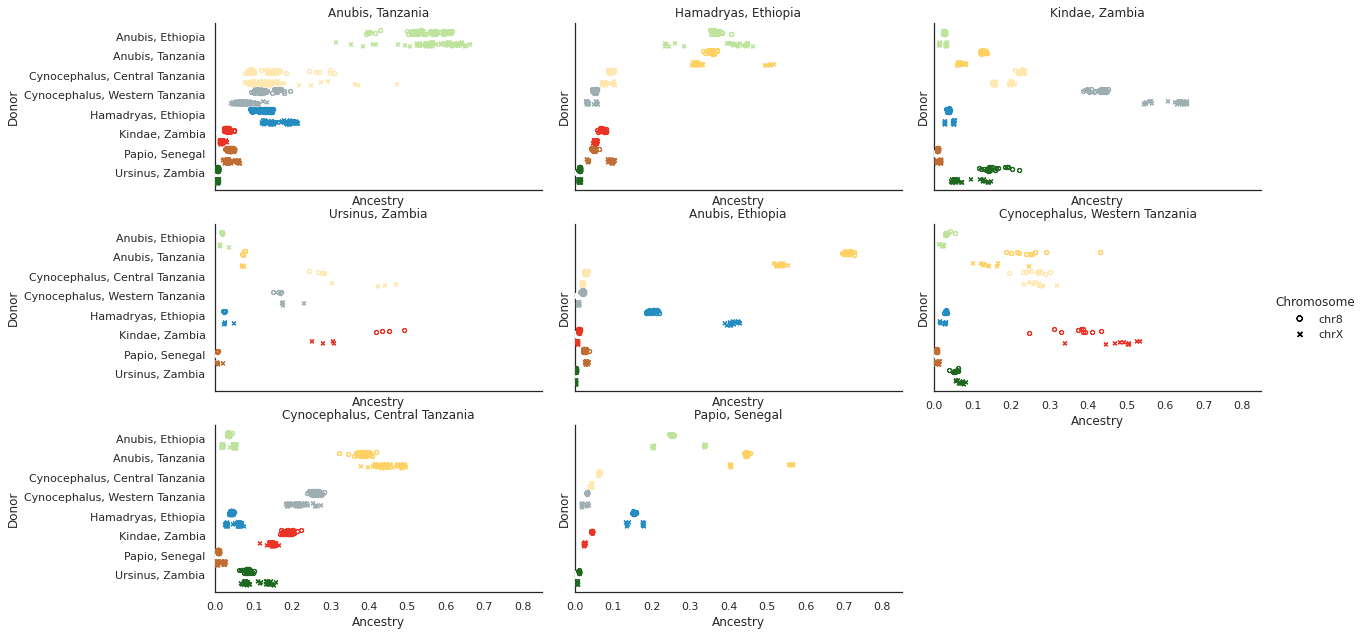

In [59]:
input_data_sub = df_length_stats_concat
input_data_sub.chrom = input_data_sub.chrom.astype("category")
input_data_sub["Population, Donor"] = input_data_sub["Population, Donor"].astype("category")
input_data_sub["Population, Location"] = input_data_sub["population"].astype("category")
input_data_sub["Population, Donor"] = input_data_sub["Population, Donor"].cat.remove_unused_categories()

palette_subset = {key: color_dir[key] for key in input_data_sub["Population, Donor"].unique()}
palette = sns.color_palette(palette_subset.values())
markers = {'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Recipient", hue="chrom", data=input_data_sub,
                      margin_titles=True, legend_out=True, height=3, aspect=2, col_wrap=3)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data_sub # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
        g.set(xlim=(0, 0.85))
    # axix labels and rotated labels (this has to be in a separate for-loop)
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")
    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr8", "chrX"])
plt.subplots_adjust(hspace = 0.2)

Quick and dirty look at windowed structure for anubis

In [81]:
test_horizon = length_to_windows(length_df_chrX_males.loc[(length_df_chrX_males.individual == "PD_0266") & (length_df_chrX_males.chrom == "chrX")])
test_horizon["PGDP_ID"] = "PD_0266"
test_horizon["chrom"] = "chrX"

In [82]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
mapping = {}
for i, row in meta_data_samples.iterrows():
    if row.PGDP_ID[0] != "P":
        mapping["Sci_"+row.PGDP_ID] = row.Origin
    else:
        mapping[row.PGDP_ID] = row.Origin

In [83]:
a_c_df = test_horizon
a_c_df["north"] = a_c_df.Anubis_Ethiopia+a_c_df.Hamadryas_Ethiopia+a_c_df.Papio_Senegal
a_c_df["norm_north"] = (a_c_df.north-a_c_df.iloc[:,1:7].sum(axis=1)/2)
a_c_df["pop"] = a_c_df["PGDP_ID"].map(mapping)
a_c_df["start"] = a_c_df["windows"]
a_c_df["norm_north"] = (a_c_df.north-a_c_df.iloc[:,1:7].sum(axis=1)/2)

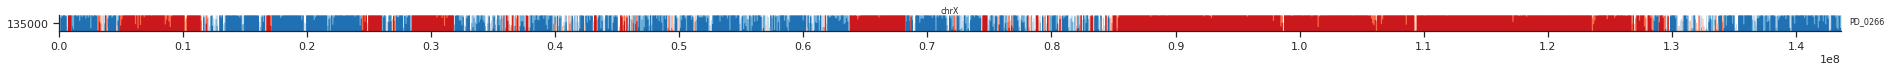

In [87]:
fig = horizonplot(a_c_df, 'norm_north', width=2, col='chrom', row='PGDP_ID', size=0.3, aspect=100)

Test scripts, not in use

In [27]:
idfile_path = "/home/eriks/baboondiversity/data/haploidified_chrX_males/idfile_males_8_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
recomb_map_path = "/home/eriks/baboondiversity/data/haploidified_chrX_males/chr{}.males.recombfile"
idfile = idfile.loc[idfile.inclusion == 1]
os.makedirs("../steps/paint_summary/", exist_ok=True)
chrom_list = []#["X"]
window_length = 100000
for chrom in chrom_list:
    recomb_map = pd.read_csv(recomb_map_path.format(chrom, chrom), sep=" ")
    pos_list = recomb_map["start.pos"]
    for population in sorted(idfile["pop"].unique())[1]:
        print(population)
        pop_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/" \
                        "chr{}_males_8_cluster/{}_chr{}_males_8_cluster/chr{}.samples.out"\
                        .format(chrom, population, chrom, chrom)
        length_df = create_paint_df_lengths(pop_path, idfile, haploid=True)
        
        for ind in idfile.loc[(idfile["pop"] == population) & (idfile.inclusion == 1)].PGDP_ID:
            name = population+"_chr"+chrom+"_8_cluster_"+ind+"_hap.txt"
            window_df = length_to_windows(length_df.loc[(length_df.individual==ind) & (length_df.haplotype==1)], window_size=window_length)
            window_df["haplotype"] = ind+"_hap1"
            window_df.to_csv("../steps/paint_summary/"+name, sep=" ", index=False)

Anubis_Tanzania
Cynocephalus_Central_Tanzania
Cynocephalus_Western_Tanzania
Hamadryas_Ethiopia
Kindae_Zambia
Papio_Senegal
Ursinus_Zambia


In [39]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
idfile_path = "/home/eriks/baboondiversity/data/haploidified_chrX_males/idfile_males_8_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index

df_l = []
for population in ['Anubis_Tanzania']:
    for chrom in ["X"]:
        for ind in idfile.loc[(idfile["pop"] == population) & (idfile.inclusion == 1)].PGDP_ID:
            name = population+"_chr"+chrom+"_8_cluster_"+ind+"_hap.txt"
            ind_df = pd.read_csv("../steps/paint_summary/"+name, sep=" ")
            ind_df["PGDP_ID"] = ind
            ind_df["chrom"] = chrom
            df_l.append(ind_df)
a_t_df = pd.concat(df_l)
a_t_df["north"] = a_t_df.Anubis_Ethiopia+a_t_df.Hamadryas_Ethiopia+a_t_df.Papio_Senegal
a_t_df["norm_north"] = (a_t_df.north-a_t_df.iloc[:,1:7].sum(axis=1)/2)

Autosomal

In [4]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chr{}/chr{}.females.recombfile"

In [13]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chr{}/chr{}.filtered.all.recombfile"

idfile = idfile.loc[idfile.inclusion == 1]
os.makedirs("../steps/paint_summary/", exist_ok=True)
chrom_list = ["8"]
window_length = 100000
for chrom in chrom_list:
    recomb_map = pd.read_csv(recomb_map_path.format(chrom, chrom), sep=" ")
    pos_list = recomb_map["start.pos"]
    for population in sorted(idfile["pop"].unique()):
        print(population)
        pop_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/" \
                        "all_autosomes_8_cluster/{}_all_autosomes_8_cluster/chr{}.samples.out"\
                        .format(population, chrom)
        length_df = create_paint_df_lengths(pop_path, idfile)
        
        for ind in idfile.loc[(idfile["pop"] == population) & (idfile.inclusion == 1)].PGDP_ID:
            name = population+"_chr"+chrom+"_8_cluster_all_"+ind+"_hap.txt"
            window_df = length_to_windows(length_df.loc[(length_df.individual==ind)], window_size=window_length)
            window_df.to_csv("../steps/paint_summary/"+name, sep=" ", index=False)

anubis_ethiopia
anubis_tanzania
cyno_central
cyno_western
hamadryas
kindae
papio
ursinus


In [16]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index

df_l = []
for population in ['anubis_tanzania']:
    for chrom in ["8"]:
        for ind in idfile.loc[(idfile["pop"] == population) & (idfile.inclusion == 1)].PGDP_ID:
            name = population+"_chr"+chrom+"_8_cluster_all_"+ind+"_hap.txt"
            ind_df = pd.read_csv("../steps/paint_summary/"+name, sep=" ")
            ind_df["PGDP_ID"] = ind
            ind_df["chrom"] = chrom
            df_l.append(ind_df)
a_t_8_df = pd.concat(df_l)

In [17]:
population = "Ursinus_Zambia"
pop_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/" \
                        "chr{}_males_8_cluster/{}_chr{}_males_8_cluster/chr{}.samples.out"\
                        .format(chrom, population, chrom, chrom)
length_df = create_paint_df_lengths(pop_path, idfile, haploid=True)